In [1]:
import  os
import  cv2
import  numpy  as  np
import  matplotlib.pyplot  as  plt
import pandas  as  pd
from glob  import  glob


In [2]:
path_data="/kaggle/input/ct-heart-segmentation/data/"

In [3]:
print(len(glob(f"{path_data}train/*/image/*.png")))
print(len(glob(f"{path_data}train/*/mask/*.png")))

2532
2532


In [4]:
def afficher_image(dataset_dir, image_filename):
    # Construire le chemin complet vers le fichier image
    image_path = os.path.join(dataset_dir, image_filename)
    print(image_path)
    
    # Vérifiez si le fichier image existe
    if os.path.exists(image_path):
        # Charger l'image avec OpenCV
        image = cv2.imread(image_path)
        
        # Convertir l'image de BGR à RGB pour l'affichage avec matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Afficher l'image avec matplotlib
        plt.imshow(image_rgb)
        plt.axis('off')  # Masquer les axes
        plt.show()
    else:
        print(f"Le fichier image {image_filename} n'existe pas dans le répertoire du dataset.")

In [5]:
image1='train/100051/image/1-081.png'
mask1='train/100051/mask/1-081.png'

/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-081.png


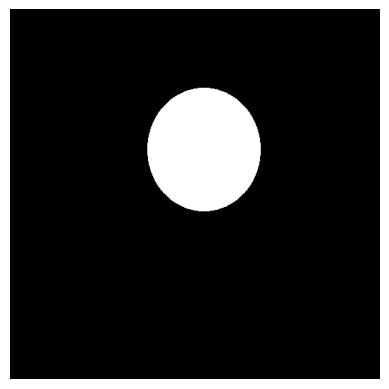

In [6]:
afficher_image(path_data,mask1)

/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-081.png


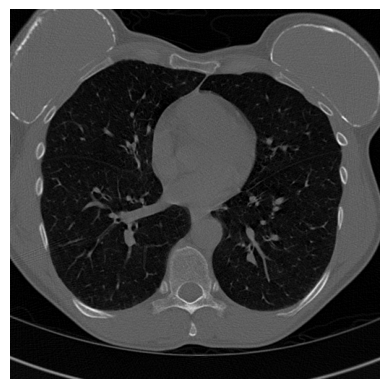

In [7]:
afficher_image(path_data,image1)

In [8]:
def create_rep(path):
  if  not  os.path.exists(path):
      os.makedirs(path)
        
  else:
    print("le  rep  deja  existe  !!")

In [9]:
from sklearn.model_selection  import  train_test_split
def  load_data(path,split=0.2):
    images = sorted(glob(f"{path}train/*/image/*.png"))
    masks = sorted(glob(f"{path}train/*/mask/*.png"))
    split_size=int(len(images)*split)
    x_train,x_valid=train_test_split(images,test_size=split_size,random_state=42)
    y_train,y_valid=train_test_split(masks,test_size=split_size,random_state=42)
    return (x_train,y_train),(x_valid,y_valid)

In [10]:
from  tqdm import  tqdm
from albumentations import HorizontalFlip, VerticalFlip, Rotate

In [11]:
def  aug_data(images,masks,save_path,augment=True):
  H=512
  W=512
  for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
      """ Extracting the dir name and image name """

      dir_name = x.split("/")[-3]
      name = dir_name + "_" + x.split("/")[-1].split(".")[0]

      """ Read the image and mask """
      x = cv2.imread(x, cv2.IMREAD_COLOR)
      y = cv2.imread(y, cv2.IMREAD_COLOR)

      if augment == True:
          aug = HorizontalFlip(p=1.0)
          augmented = aug(image=x, mask=y)
          x1 = augmented["image"]
          y1 = augmented["mask"]

          aug = VerticalFlip(p=1)
          augmented = aug(image=x, mask=y)
          x2 = augmented['image']
          y2 = augmented['mask']

          aug = Rotate(limit=45, p=1.0)
          augmented = aug(image=x, mask=y)
          x3 = augmented["image"]
          y3 = augmented["mask"]

          X = [x, x1, x2, x3]
          Y = [y, y1, y2, y3]

      else:
          X = [x]
          #print(len(X))
          Y =[y]

      idx = 0
      for i, m in zip(X, Y):
          i = cv2.resize(i, (W, H))
          m = cv2.resize(m, (W, H))
          m = m/255.0
          m = (m > 0.5) * 255

          if len(X) == 1:  # each loop it will take one image
              tmp_image_name = f"{name}.jpg"
              tmp_mask_name  = f"{name}.jpg"
          else:
              tmp_image_name = f"{name}_{idx}.jpg"
              tmp_mask_name  = f"{name}_{idx}.jpg"

          image_path = os.path.join(save_path, "images/", tmp_image_name)
          mask_path  = os.path.join(save_path, "masks/", tmp_mask_name)

          cv2.imwrite(image_path, i)
          cv2.imwrite(mask_path, m)
          idx += 1


In [12]:
(x_train,y_train),(x_valid,y_valid)=load_data(path_data)
print('train',len(x_train))
print("valid",len(x_valid))

train 2026
valid 506


In [13]:
new_path="/kaggle/working"
create_rep(f"{new_path}/new_data/train/images")
create_rep(f"{new_path}/new_data/train/masks")
create_rep(f"{new_path}/new_data/valid/images")
create_rep(f"{new_path}/new_data/valid/masks")

In [14]:
aug_data(x_train,y_train, f"{new_path}/new_data/train/", augment=True)
aug_data(x_valid, y_valid, f"{new_path}/new_data/valid/", augment=False)

100%|██████████| 506/506 [00:11<00:00, 44.24it/s]


In [19]:
print(len(glob(f"{new_path}/new_data/train/*/*.jpg")))
print(len(glob(f"{new_path}/new_data/valid/*/*.jpg")))

16208
1012


In [20]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

In [21]:

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model




In [22]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [23]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision


H = 512
W = 512

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*.jpg")))
    y = sorted(glob(os.path.join(path, "masks", "*.jpg")))
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    #print(f"Image shape: {x.shape}")
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    #print(f"Image shape: {x.shape}")
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset




In [24]:

""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 10
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

""" Dataset """
dataset_path = os.path.join("/kaggle/working/new_data/")
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Train dataset length: {len(train_x)}, Validation dataset length: {len(valid_x)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

""" Model """
model = unet((H, W, 3))
metrics = [dice_coefficient, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)



Train: 8104 - 8104
Valid: 506 - 506
Train dataset length: 8104, Validation dataset length: 506


In [25]:
callbacks = [
    ModelCheckpoint(model_path + ".keras", verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False),
]



In [26]:

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    shuffle=False,
    verbose=2
)

Epoch 1/10


2024-08-10 08:54:18.214186: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,256,256,256]{3,2,1,0}, f32[2,128,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-10 08:54:18.322491: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.108504151s
Trying algorithm eng0{} for conv (f32[128,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,256,256,256]{3,2,1,0}, f32[2,128,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-10 08:54:20.447124: E exter


Epoch 1: val_loss improved from inf to 0.68886, saving model to files/model.h5.keras
4052/4052 - 1984s - 490ms/step - dice_coefficient: 0.4378 - iou: 0.3648 - loss: 0.5622 - precision: 0.4262 - recall: 0.8145 - val_dice_coefficient: 0.3111 - val_iou: 0.2570 - val_loss: 0.6889 - val_precision: 0.4602 - val_recall: 0.8999 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss did not improve from 0.68886
4052/4052 - 1886s - 466ms/step - dice_coefficient: 0.5161 - iou: 0.4604 - loss: 0.4839 - precision: 0.5673 - recall: 0.8687 - val_dice_coefficient: 0.2697 - val_iou: 0.2084 - val_loss: 0.7303 - val_precision: 0.1838 - val_recall: 0.9540 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 0.68886 to 0.63883, saving model to files/model.h5.keras
4052/4052 - 1889s - 466ms/step - dice_coefficient: 0.5309 - iou: 0.4804 - loss: 0.4691 - precision: 0.6099 - recall: 0.8851 - val_dice_coefficient: 0.3612 - val_iou: 0.3217 - val_loss: 0.6388 - val_precision: 0.6866 - val_re

In [29]:
from tensorflow.keras.models import load_model
 # Importez les fonctions que vous avez utilisées

model2 = load_model('/kaggle/working/model.h5', custom_objects={
    'dice_loss': dice_loss,
    'dice_coefficient': dice_coefficient,
    'iou': iou
})


In [32]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


H = 512
W = 512

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    ## i - m - y
    line = np.ones((H, 10, 3)) * 128

    """ Mask """
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)

    """ Predicted Mask """
    y_pred = np.expand_dims(y_pred, axis=-1)    ## (512, 512, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  ## (512, 512, 3)
    y_pred = y_pred * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/kaggle/working/results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coefficient': dice_coefficient, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/kaggle/working/model.h5")

    """ Load the dataset """
    test_x = sorted(glob(os.path.join("/kaggle/working/new_data", "valid", "images", "*")))
    test_y = sorted(glob(os.path.join("/kaggle/working/new_data", "valid", "masks", "*")))
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Evaluation and Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = mask/255.0
        y = y > 0.5
        y = y.astype(np.int32)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = f"/kaggle/working/results/{name}.png"
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/kaggle/working/files/score.csv")

Test: 506 - 506


  0%|          | 0/506 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


  0%|          | 1/506 [00:15<2:13:26, 15.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 2/506 [00:16<55:53,  6.65s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 3/506 [00:16<32:05,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 4/506 [00:16<20:52,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|          | 5/506 [00:17<14:50,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 6/506 [00:17<11:08,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▏         | 7/506 [00:18<08:56,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 8/506 [00:19<07:44,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 9/506 [00:19<06:55,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 10/506 [00:20<06:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 11/506 [00:21<06:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 12/506 [00:21<05:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 13/506 [00:22<05:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 14/506 [00:22<05:23,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 15/506 [00:23<05:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 16/506 [00:24<05:18,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 17/506 [00:24<05:20,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▎         | 18/506 [00:25<04:54,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 19/506 [00:25<04:34,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 20/506 [00:26<03:43,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 21/506 [00:26<03:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 22/506 [00:26<03:48,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 23/506 [00:27<04:12,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 24/506 [00:28<04:26,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 25/506 [00:28<04:37,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 26/506 [00:29<04:43,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 27/506 [00:30<04:46,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 28/506 [00:30<04:54,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 29/506 [00:31<04:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 30/506 [00:32<04:56,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 31/506 [00:32<04:58,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▋         | 32/506 [00:33<04:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 33/506 [00:33<04:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 34/506 [00:34<04:31,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 35/506 [00:34<04:14,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 36/506 [00:35<03:29,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 37/506 [00:35<02:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 38/506 [00:35<02:36,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 39/506 [00:35<02:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 40/506 [00:35<02:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 41/506 [00:36<02:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 42/506 [00:36<02:29,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 43/506 [00:36<02:18,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▊         | 44/506 [00:37<02:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 45/506 [00:37<02:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 46/506 [00:37<02:29,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 47/506 [00:38<02:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 48/506 [00:38<02:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|▉         | 49/506 [00:38<01:57,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 50/506 [00:38<01:54,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 51/506 [00:38<01:50,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█         | 52/506 [00:39<02:21,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 53/506 [00:39<02:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 54/506 [00:40<03:19,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 55/506 [00:41<03:47,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 56/506 [00:41<04:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█▏        | 57/506 [00:42<04:13,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█▏        | 58/506 [00:43<04:23,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 59/506 [00:43<04:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 60/506 [00:44<04:33,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 61/506 [00:44<04:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 62/506 [00:45<04:33,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 63/506 [00:46<04:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 64/506 [00:46<04:15,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 65/506 [00:47<04:04,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 66/506 [00:47<03:52,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 67/506 [00:48<03:44,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 68/506 [00:48<03:43,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▎        | 69/506 [00:48<03:07,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 70/506 [00:49<02:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 71/506 [00:49<02:23,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 72/506 [00:49<02:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 73/506 [00:49<01:59,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▍        | 74/506 [00:50<01:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▍        | 75/506 [00:50<01:47,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 76/506 [00:50<01:44,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▌        | 77/506 [00:51<02:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 78/506 [00:51<03:12,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▌        | 79/506 [00:52<03:36,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 80/506 [00:53<03:53,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▌        | 81/506 [00:53<04:00,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 82/506 [00:54<04:05,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▋        | 83/506 [00:54<04:15,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 84/506 [00:55<04:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 85/506 [00:56<04:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 86/506 [00:56<04:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 87/506 [00:57<04:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 88/506 [00:58<04:24,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 89/506 [00:58<04:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 90/506 [00:59<04:23,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 91/506 [01:00<04:21,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 92/506 [01:00<04:01,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 93/506 [01:01<03:53,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▊        | 94/506 [01:01<03:40,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 95/506 [01:01<03:32,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 96/506 [01:02<03:28,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 97/506 [01:02<03:23,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 98/506 [01:03<03:19,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|█▉        | 99/506 [01:03<02:46,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|█▉        | 100/506 [01:04<02:53,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|█▉        | 101/506 [01:04<02:58,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|██        | 102/506 [01:05<03:02,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|██        | 103/506 [01:05<03:04,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 104/506 [01:05<03:05,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 105/506 [01:06<03:07,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 106/506 [01:06<02:38,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 107/506 [01:06<02:17,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██▏       | 108/506 [01:07<02:33,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 109/506 [01:07<02:13,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 110/506 [01:07<02:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 111/506 [01:08<01:50,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 112/506 [01:08<02:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 113/506 [01:09<03:03,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 114/506 [01:10<03:25,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 115/506 [01:10<03:40,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 116/506 [01:11<03:48,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 117/506 [01:11<03:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 118/506 [01:12<03:55,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▎       | 119/506 [01:13<04:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▎       | 120/506 [01:13<04:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 121/506 [01:14<04:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 122/506 [01:15<04:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 123/506 [01:15<03:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 124/506 [01:16<03:29,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▍       | 125/506 [01:16<03:21,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▍       | 126/506 [01:17<03:13,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 127/506 [01:17<02:41,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 128/506 [01:17<02:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 129/506 [01:17<02:02,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 130/506 [01:17<01:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 131/506 [01:18<01:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 132/506 [01:18<01:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▋       | 133/506 [01:18<01:35,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▋       | 134/506 [01:18<01:32,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 135/506 [01:19<01:30,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 136/506 [01:19<01:57,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 137/506 [01:20<02:36,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 138/506 [01:20<03:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 139/506 [01:21<03:14,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 140/506 [01:22<03:07,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 141/506 [01:22<03:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 142/506 [01:22<02:59,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 143/506 [01:23<02:57,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 144/506 [01:23<02:30,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▊       | 145/506 [01:23<02:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 146/506 [01:24<01:56,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 147/506 [01:24<01:44,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 148/506 [01:24<01:37,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 149/506 [01:24<01:32,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|██▉       | 150/506 [01:25<01:28,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|██▉       | 151/506 [01:25<01:25,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 152/506 [01:25<01:23,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 153/506 [01:25<01:21,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 154/506 [01:25<01:20,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 155/506 [01:26<01:19,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 156/506 [01:26<01:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 157/506 [01:26<01:17,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 158/506 [01:26<01:18,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███▏      | 159/506 [01:27<01:18,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 160/506 [01:27<01:18,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 161/506 [01:27<01:42,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 162/506 [01:28<02:15,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 163/506 [01:29<02:40,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 164/506 [01:29<02:55,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 165/506 [01:30<03:08,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 166/506 [01:30<03:18,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 167/506 [01:31<03:21,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 168/506 [01:32<03:24,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 169/506 [01:32<03:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▎      | 170/506 [01:33<03:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 171/506 [01:34<03:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 172/506 [01:34<03:32,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 173/506 [01:35<03:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 174/506 [01:36<03:29,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▍      | 175/506 [01:36<03:27,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 176/506 [01:37<03:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▍      | 177/506 [01:37<03:14,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 178/506 [01:38<03:02,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 179/506 [01:38<02:29,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 180/506 [01:38<02:07,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 181/506 [01:38<01:51,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 182/506 [01:39<01:40,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▌      | 183/506 [01:39<01:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▋      | 184/506 [01:39<01:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 185/506 [01:40<01:45,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 186/506 [01:40<02:16,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 187/506 [01:41<02:19,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 188/506 [01:41<01:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███▋      | 189/506 [01:41<01:44,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 190/506 [01:41<01:34,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 191/506 [01:42<01:27,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 192/506 [01:42<01:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 193/506 [01:42<01:18,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 194/506 [01:42<01:16,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 195/506 [01:43<01:14,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 196/506 [01:43<01:13,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 197/506 [01:43<01:12,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 198/506 [01:43<01:11,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 199/506 [01:43<01:10,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███▉      | 200/506 [01:44<01:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 201/506 [01:44<01:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███▉      | 202/506 [01:45<02:11,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 203/506 [01:46<02:28,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 204/506 [01:46<02:41,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 205/506 [01:47<02:50,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 206/506 [01:48<02:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 207/506 [01:48<03:00,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 208/506 [01:49<03:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████▏     | 209/506 [01:49<03:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 210/506 [01:50<03:12,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 211/506 [01:51<03:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 42%|████▏     | 212/506 [01:52<03:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 213/506 [01:52<03:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 214/506 [01:53<03:07,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 215/506 [01:53<03:05,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 216/506 [01:54<03:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 217/506 [01:55<03:08,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 218/506 [01:55<03:06,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 219/506 [01:56<02:30,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 220/506 [01:56<02:25,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▎     | 221/506 [01:57<02:22,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 222/506 [01:57<01:58,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 223/506 [01:57<01:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 224/506 [01:57<01:30,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 225/506 [01:58<01:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 226/506 [01:58<01:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 227/506 [01:58<01:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 228/506 [01:59<01:51,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▌     | 229/506 [01:59<01:38,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 230/506 [01:59<01:28,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▌     | 231/506 [02:00<01:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 232/506 [02:00<01:28,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 46%|████▌     | 233/506 [02:00<01:21,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▌     | 234/506 [02:01<01:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████▋     | 235/506 [02:01<01:10,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 236/506 [02:01<01:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 237/506 [02:01<01:26,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 238/506 [02:02<01:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 239/506 [02:02<01:47,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 240/506 [02:03<02:04,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|████▊     | 241/506 [02:04<02:16,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 242/506 [02:04<02:24,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 243/506 [02:05<02:31,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 244/506 [02:06<02:34,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 245/506 [02:06<02:39,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▊     | 246/506 [02:07<02:40,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▉     | 247/506 [02:08<02:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▉     | 248/506 [02:08<02:46,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▉     | 249/506 [02:09<02:45,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▉     | 250/506 [02:09<02:43,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████▉     | 251/506 [02:10<02:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 50%|████▉     | 252/506 [02:11<02:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 253/506 [02:11<02:43,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████     | 254/506 [02:12<02:41,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 255/506 [02:13<02:28,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 256/506 [02:13<02:18,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 257/506 [02:13<02:12,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████     | 258/506 [02:14<02:09,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████     | 259/506 [02:14<02:08,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████▏    | 260/506 [02:15<02:05,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 261/506 [02:15<02:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 262/506 [02:16<02:00,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 263/506 [02:16<01:58,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████▏    | 264/506 [02:17<01:38,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 265/506 [02:17<01:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 266/506 [02:17<01:16,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 267/506 [02:18<01:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 268/506 [02:18<01:38,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 269/506 [02:19<01:43,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 270/506 [02:19<01:57,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▎    | 271/506 [02:20<02:06,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▍    | 272/506 [02:21<02:15,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|█████▍    | 273/506 [02:21<02:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 274/506 [02:21<01:46,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 54%|█████▍    | 275/506 [02:22<01:31,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▍    | 276/506 [02:22<01:37,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▍    | 277/506 [02:22<01:41,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▍    | 278/506 [02:23<01:43,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 279/506 [02:23<01:27,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 280/506 [02:23<01:15,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▌    | 281/506 [02:24<01:07,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▌    | 282/506 [02:24<01:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 283/506 [02:24<00:59,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▌    | 284/506 [02:24<00:55,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▋    | 285/506 [02:25<00:53,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 286/506 [02:25<00:52,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 287/506 [02:25<00:50,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 288/506 [02:25<00:49,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 289/506 [02:25<00:49,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 290/506 [02:26<00:49,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 291/506 [02:26<00:48,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 292/506 [02:26<00:48,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 293/506 [02:26<00:47,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 294/506 [02:27<01:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 295/506 [02:27<01:14,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 296/506 [02:28<01:30,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 59%|█████▊    | 297/506 [02:29<01:42,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 298/506 [02:29<01:50,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 299/506 [02:30<01:55,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 300/506 [02:30<02:00,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 301/506 [02:31<02:03,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|█████▉    | 302/506 [02:32<02:05,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|█████▉    | 303/506 [02:32<02:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 304/506 [02:33<02:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|██████    | 305/506 [02:34<02:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 306/506 [02:34<01:56,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████    | 307/506 [02:35<01:51,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████    | 308/506 [02:35<01:45,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████    | 309/506 [02:35<01:26,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████▏   | 310/506 [02:36<01:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████▏   | 311/506 [02:36<01:04,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 312/506 [02:36<00:57,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 313/506 [02:36<00:52,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 314/506 [02:36<00:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 315/506 [02:37<00:47,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 316/506 [02:37<00:46,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 317/506 [02:37<00:44,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 318/506 [02:38<00:57,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 319/506 [02:38<01:15,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 320/506 [02:39<01:29,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 321/506 [02:39<01:37,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▎   | 322/506 [02:40<01:44,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 323/506 [02:41<01:48,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 324/506 [02:41<01:49,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 325/506 [02:42<01:50,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 326/506 [02:43<01:53,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 327/506 [02:43<01:52,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 328/506 [02:44<01:52,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 329/506 [02:45<01:51,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 330/506 [02:45<01:50,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▌   | 331/506 [02:46<01:42,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 332/506 [02:46<01:36,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 333/506 [02:47<01:32,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 334/506 [02:47<01:29,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 335/506 [02:47<01:14,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▋   | 336/506 [02:48<01:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 337/506 [02:48<00:55,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 338/506 [02:48<00:50,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 339/506 [02:48<00:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 340/506 [02:49<00:44,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 341/506 [02:49<00:42,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 342/506 [02:49<00:53,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 343/506 [02:50<01:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 68%|██████▊   | 344/506 [02:50<01:12,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 345/506 [02:51<01:22,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 346/506 [02:52<01:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▊   | 347/506 [02:52<01:30,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▉   | 348/506 [02:53<01:35,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 349/506 [02:54<01:36,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 350/506 [02:54<01:37,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 351/506 [02:55<01:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████▉   | 352/506 [02:56<01:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████▉   | 353/506 [02:56<01:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 354/506 [02:57<01:29,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 355/506 [02:57<01:24,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 356/506 [02:57<01:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 357/506 [02:58<00:58,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 358/506 [02:58<00:50,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 359/506 [02:58<00:45,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 360/506 [02:58<00:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████▏  | 361/506 [02:59<00:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 362/506 [02:59<00:37,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 363/506 [02:59<00:35,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 364/506 [02:59<00:35,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 365/506 [02:59<00:33,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|███████▏  | 366/506 [03:00<00:32,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 367/506 [03:00<00:32,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 368/506 [03:00<00:31,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 369/506 [03:00<00:31,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 73%|███████▎  | 370/506 [03:01<00:31,  4.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 371/506 [03:01<00:40,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▎  | 372/506 [03:02<00:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▎  | 373/506 [03:02<00:57,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 374/506 [03:03<01:05,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 375/506 [03:03<01:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 376/506 [03:04<01:13,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▍  | 377/506 [03:05<01:15,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▍  | 378/506 [03:05<01:16,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▍  | 379/506 [03:06<01:17,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▌  | 380/506 [03:07<01:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 381/506 [03:07<01:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 382/506 [03:08<01:08,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 383/506 [03:08<01:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 384/506 [03:09<01:03,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 385/506 [03:09<01:01,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▋  | 386/506 [03:09<00:59,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▋  | 387/506 [03:10<00:58,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 388/506 [03:10<00:58,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 389/506 [03:11<00:57,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 390/506 [03:11<00:56,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 391/506 [03:12<00:56,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 392/506 [03:12<00:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 393/506 [03:13<00:54,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 394/506 [03:13<00:53,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 395/506 [03:14<00:53,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 396/506 [03:14<00:56,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 397/506 [03:15<00:59,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▊  | 398/506 [03:16<01:02,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 399/506 [03:16<01:03,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 400/506 [03:17<01:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 401/506 [03:18<01:03,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 402/506 [03:18<01:04,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 403/506 [03:19<01:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|███████▉  | 404/506 [03:19<01:04,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|████████  | 405/506 [03:20<01:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|████████  | 406/506 [03:21<01:03,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 407/506 [03:21<01:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 408/506 [03:22<00:57,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 409/506 [03:22<00:53,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████  | 410/506 [03:23<00:44,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████  | 411/506 [03:23<00:37,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████▏ | 412/506 [03:23<00:32,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 413/506 [03:23<00:28,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 414/506 [03:24<00:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|████████▏ | 415/506 [03:24<00:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 416/506 [03:24<00:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 417/506 [03:24<00:23,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 418/506 [03:24<00:21,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 419/506 [03:25<00:21,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 420/506 [03:25<00:20,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 421/506 [03:25<00:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 422/506 [03:26<00:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▎ | 423/506 [03:26<00:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▍ | 424/506 [03:26<00:21,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 425/506 [03:26<00:20,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 426/506 [03:27<00:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 427/506 [03:27<00:18,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▍ | 428/506 [03:27<00:23,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 429/506 [03:28<00:27,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 430/506 [03:28<00:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 431/506 [03:29<00:34,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▌ | 432/506 [03:29<00:38,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▌ | 433/506 [03:30<00:41,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▌ | 434/506 [03:31<00:42,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|████████▌ | 435/506 [03:31<00:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▌ | 436/506 [03:32<00:42,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▋ | 437/506 [03:33<00:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 438/506 [03:33<00:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 439/506 [03:34<00:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 440/506 [03:35<00:41,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 441/506 [03:35<00:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 442/506 [03:36<00:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 443/506 [03:37<00:40,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 444/506 [03:37<00:39,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 445/506 [03:38<00:38,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 446/506 [03:38<00:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 447/506 [03:39<00:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▊ | 448/506 [03:39<00:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▊ | 449/506 [03:40<00:26,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 450/506 [03:40<00:26,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▉ | 451/506 [03:41<00:26,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 452/506 [03:41<00:25,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 453/506 [03:41<00:21,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 454/506 [03:42<00:21,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|████████▉ | 455/506 [03:42<00:18,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|█████████ | 456/506 [03:42<00:15,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|█████████ | 457/506 [03:43<00:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 458/506 [03:43<00:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 459/506 [03:43<00:12,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 460/506 [03:43<00:11,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 461/506 [03:43<00:10,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████▏| 462/506 [03:44<00:10,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 463/506 [03:44<00:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 464/506 [03:45<00:18,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 465/506 [03:46<00:20,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 466/506 [03:46<00:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 467/506 [03:47<00:22,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 468/506 [03:47<00:22,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 469/506 [03:48<00:22,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 470/506 [03:49<00:20,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 471/506 [03:49<00:19,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 472/506 [03:49<00:15,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 473/506 [03:50<00:15,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▎| 474/506 [03:50<00:12,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 475/506 [03:50<00:12,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 476/506 [03:51<00:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 477/506 [03:51<00:09,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 478/506 [03:51<00:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▍| 479/506 [03:52<00:09,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|█████████▍| 480/506 [03:52<00:08,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 481/506 [03:52<00:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 482/506 [03:53<00:09,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 483/506 [03:53<00:09,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 484/506 [03:54<00:09,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 485/506 [03:54<00:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 486/506 [03:54<00:06,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 487/506 [03:54<00:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 96%|█████████▋| 488/506 [03:55<00:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 489/506 [03:55<00:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 490/506 [03:56<00:06,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 491/506 [03:56<00:07,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 492/506 [03:57<00:07,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 493/506 [03:58<00:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 494/506 [03:58<00:07,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 495/506 [03:59<00:06,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 496/506 [04:00<00:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 497/506 [04:00<00:05,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 498/506 [04:01<00:05,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▊| 499/506 [04:01<00:04,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 500/506 [04:02<00:03,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 501/506 [04:02<00:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 502/506 [04:03<00:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 503/506 [04:03<00:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|█████████▉| 504/506 [04:03<00:00,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|█████████▉| 505/506 [04:03<00:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|██████████| 506/506 [04:04<00:00,  2.07it/s]

Accuracy: 0.99040
F1: 0.69618
Jaccard: 0.67113
Recall: 0.95785
Precision: 0.70819


/kaggle/working/results/100094_1-096.png


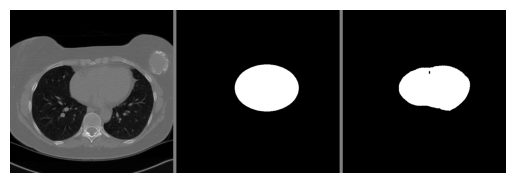

In [33]:
afficher_image("/kaggle/working/results","/kaggle/working/results/100094_1-096.png")

/kaggle/working/results/100095_1-038.png


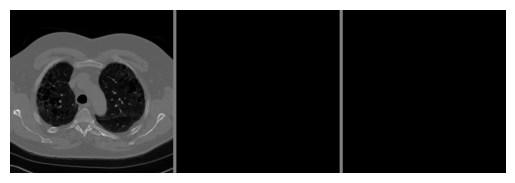

In [35]:

afficher_image("/kaggle/working/results","/kaggle/working/results/100095_1-038.png")

/kaggle/working/results/100092_1-071.png


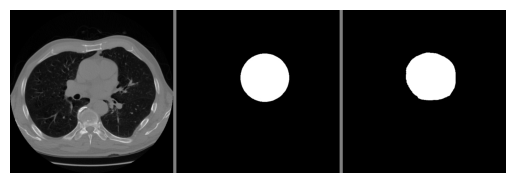

In [39]:
afficher_image("/kaggle/working/results","/kaggle/working/results/100092_1-071.png")

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tqdm import tqdm  # Assurez-vous que tqdm est installé

# Chemins des répertoires d'images et de masques
path = "/kaggle/working/new_data/"
train_img_dir = os.path.join(path, "train/images")
train_mask_dir = os.path.join(path, "train/masks")
val_img_dir = os.path.join(path, "valid/images")
val_mask_dir = os.path.join(path, "valid/masks")

# Arguments pour normaliser les valeurs des pixels (de 0-255 à 0-1)
img_data_gen_args = dict(rescale=1./255)
mask_data_gen_args = dict(rescale=1./255)

# Fonction pour charger les images et masques
def load_images_and_masks(image_dir, mask_dir, target_size=(512, 512)):
    images = []
    masks = []
    
    img_names = os.listdir(image_dir)
    for img_name in tqdm(img_names, desc=f"Loading images from {image_dir}", unit='image'):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        
        if os.path.isfile(img_path) and os.path.isfile(mask_path):
            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, color_mode="grayscale", target_size=target_size)
            
            images.append(img_to_array(img))
            masks.append(img_to_array(mask))
    
    return np.array(images), np.array(masks)

# Chargement des images et masques
train_images, train_masks = load_images_and_masks(train_img_dir, train_mask_dir)
val_images, val_masks = load_images_and_masks(val_img_dir, val_mask_dir)

# Création des générateurs
image_datagen = ImageDataGenerator(**img_data_gen_args)
mask_datagen = ImageDataGenerator(**mask_data_gen_args)

train_img_gen = image_datagen.flow(train_images, batch_size=16, seed=42)
train_mask_gen = mask_datagen.flow(train_masks, batch_size=16, seed=42)

val_img_gen = image_datagen.flow(val_images, batch_size=16, seed=42)
val_mask_gen = mask_datagen.flow(val_masks, batch_size=16, seed=42)

# Combinaison des générateurs d'images et de masques
train_generator = zip(train_img_gen, train_mask_gen)
val_generator = zip(val_img_gen, val_mask_gen)

print("Images d'entraînement :", len(train_images))
print("Masques d'entraînement :", len(train_masks))
print("Images de validation :", len(val_images))
print("Masques de validation :", len(val_masks))


Loading images from /kaggle/working/new_data/train/images:  89%|████████▉ | 7222/8104 [00:51<00:16, 53.01image/s] 